## Data curation continued
--- 
`NEW CONTINUING` script from the first [data_curation](../notebooks/data_curation.ipynb) script. 

Data processing pipeline: 
- [`data_curation.ipynb`](../notebooks/data_curation.ipynb)
- `data_curation_cont.ipynb` << You are here.
- [`data_analysis.ipynb`](../notebooks/data_analysis.ipynb)


### Table of contents
> [Overview](#overview)
>
> [SLABank data](#new-slabank-data)
>
> [Augmenting L2 Metadata](#augmenting-the-l2-metadata)
>
> [Visualization](#visualizations)
>
> [Saving data](#saving-data)

In [1]:
# loading required libraries
import nltk, pickle, pprint, csv, re, pylangacq
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# pretty printing for readability
cp = pprint.PrettyPrinter(compact=True, sort_dicts=True)

# loading data from last notebook
Lcorpus = pickle.load(open("../data/Lcorpus.pkl", 'rb'))
Ncorpus = pickle.load(open("../data/Ncorpus.pkl", 'rb'))

---
### Overview

Continuing my data curation efforts after first [progress report](../progress_report.md). In the last notebook, some issues were encountered, namely, the learner corpus may not be appropriate/contain sufficient data for my analysis. Thus, my first step is to delve into more exploration of that data to see if it will suffice. Following this, I will begin to investigate specific morphemes that are salient in the texts.

--- 

In [2]:
Lcorpus.head()

,Filename,Proficiency,Age,L1,Age_Exposure,Years_Study,Text
0,DE_SP_B1_26_13_13_TM,B1,26,German,8,13.0,One day Tommy found a frog in a forest and bro...
1,DE_SP_B1_19_11_13_RN,B1,19,German,10,11.0,One day a little boy called John uh with his d...
2,DE_SP_B1_21_12_13_SE,B1,21,German,9,12.0,One day a boy was sitting in his room / uh he ...
3,DE_SP_B1_22_15_13_LF,B1,22,German,7,15.0,Uh one day a little boy and his dog are watchi...
4,DE_SP_B1_33_10_14_JR,B1,33,German,10,10.0,Ok this story is about toch uh Charles Chaplin...


In [3]:
Lcorpus_7 = Lcorpus[Lcorpus.Years_Study <= 7]
print(len(Lcorpus))
print(len(Lcorpus_7))

350
14


There are only 14 samples out of the 350 learners in this corpus that have been studying English for 7 years or less. Therefore, most data is from learners who are likely past the stages of acquisition where they would be acquiring basic morphemes.

In [4]:
Lcorpus_7.head()

,Filename,Proficiency,Age,L1,Age_Exposure,Years_Study,Text
180,ES_SP_A2_50_6_14_MJRC,A2,50,Spanish,38,6.0,uh well uh this video / this story is about uh...
181,ES_SP_A2_18_3_14_PAMM,A2,18,Spanish,15,3.0,hhh uh Charles Chaplin hhh was walking and smo...
182,ES_SP_A2_19_2_13_ERO,A2,19,Spanish,17,2.0,uh one day hhh they boy and her / his dog hhh ...
185,ES_SP_A2_26_3_14_SM,A2,26,Spanish,11,3.0,hi in this video we can look uh at a you can w...
189,ES_SP_A2_23_4_14_B,A2,23,Spanish,16,4.0,hello / my name is / ryan 'n' / 'n' this video...


In [5]:
Lcorpus_7.L1.nunique()

1

Additionally, they all share an L1, Spanish. This sample is not likely to provide an adequate amount of data for my analysis. It would also be restricted to a single L1, which isn't ideal for making generalizations about all English language learners, especially since Spanish is similar to English in quite a few aspects of morphology. Unfortunately I will be scrapping this data set for this project.

---

### New SLABank data

While it would have been interesting to leverage two totally unique corpora sources for this analysis, the cons for CORFL were too substantial. It has proven challenging to find additional spoken, transcribed, English learner corpora that are _freely_ available online, so I will resort to using additional corpora from the TalkBank family. 

These corpora come from SLABank rather than CHILDES. In addition, this time I will source data from a corpus that was compiled at an Intensive English Program (IEP), so it will contain learners with a variety of L1's.

Sampling Vercellotti corpus using `PyLangAcq`:

In [6]:
# setting path
path = '../data/SLABank/Vercellotti'

Verce = pylangacq.read_chat(path) # creating a reader object

In [7]:
print(type(Verce))
print(Verce.n_files()) # info about this object

<class 'pylangacq.chat.Reader'>
293


In [8]:
cp.pprint(Verce.headers()[0]) # checking stored metadata for first CHAT file

{'Languages': ['eng'],
 'Media': '1060_3G1, audio',
 'Options': 'multi',
 'PID': '11312/t-00010086-1',
 'Participants': {'1060': {'age': '',
                           'corpus': 'Vercellotti',
                           'custom': '',
                           'education': 'level4',
                           'group': '1',
                           'language': 'eng',
                           'name': 'Student',
                           'role': 'Student',
                           'ses': '',
                           'sex': ''}},
 'Transcriber': 'mlv',
 'UTF8': ''}


Looks like Vercellotti is missing crucial metadata. Age and time spent learning English is not included, which again is very problematic. We do have what may be a proficiency level stored as `education` and a variable called `group` that again may prove useful.

*Luckily*, I can reconcile this issue with student info metadata obtained from [PELIC](https://eli-data-mining-group.github.io/Pitt-ELI-Corpus/), from which Vercellotti's corpus is actually sourced. First, I will get the data from CHAT format into a dataframe.

In [9]:
Verce.headers()[0]

{'UTF8': '',
 'PID': '11312/t-00010086-1',
 'Languages': ['eng'],
 'Participants': {'1060': {'name': 'Student',
   'language': 'eng',
   'corpus': 'Vercellotti',
   'age': '',
   'sex': '',
   'group': '1',
   'ses': '',
   'role': 'Student',
   'education': 'level4',
   'custom': ''}},
 'Options': 'multi',
 'Media': '1060_3G1, audio',
 'Transcriber': 'mlv'}

In [10]:
# initiating empty lists
file_path_list = []
participant_list = []
group_list = []
edu_list = []
tokens_list = []
pos_list = []
mor_list = []

# read entire corpus into a Reader object
Vercorpus = pylangacq.read_chat(path)
# compiling data into lists

for f in Vercorpus:
    file_path = f.file_paths()[0].split('/')[3]
    pos = []
    mor = []
    words = pylangacq.Reader.words(f)
    for token in pylangacq.Reader.tokens(f):
        pos.append(token.pos)
        mor.append(token.mor)
    for p in f.headers()[0]['Participants']:
        if re.match(r'^[0-9]{4}$', p):
            participant = p
            group = f.headers()[0]['Participants'][p]['group']
            edu = f.headers()[0]['Participants'][p]['education']
            file_path_list.append(file_path)
            participant_list.append(p)
            group_list.append(group)
            edu_list.append(edu)
            tokens_list.append(words)
            pos_list.append(pos)
            mor_list.append(mor)

In [11]:
# building the dataframe
Vercorpus = pd.DataFrame({'Filename':file_path_list,
                            'Participant':participant_list,
                             'Group':group_list,
                             'Education':edu_list,
                             'Tokens':tokens_list,
                             'POS':pos_list,
                             'Morphemes':mor_list})

In [12]:
Vercorpus.head()

,Filename,Participant,Group,Education,Tokens,POS,Morphemes
0,Vercellotti\1060_3G1.cha,1060,1,level4,"[my, topic, is, describe, your, favorite, meal...","[det:poss, n, cop, v, det:poss, adj, n, prep, ...","[my, topic, be&3S, describe, your, favorite, m..."
1,Vercellotti\1060_3G2.cha,1060,2,level4,"[the, topic, is, transportation, ., in, this, ...","[det:art, n, cop, n, ., prep, det:dem, n, qn, ...","[the, topic, be&3S, transport&dv-ATION, , in, ..."
2,Vercellotti\1060_3G3.cha,1060,3,level4,"[the, topic, is, someone, I, admire, ., I'll, ...","[det:art, n, cop, pro:indef, pro:sub, v, ., pr...","[the, topic, be&3S, someone, I, admire, , I, w..."
3,Vercellotti\1060_4P1.cha,1060,1,level4,"[the, topic, is, talking, about, a, problem, i...","[det:art, n, aux, part, prep, det:art, n, prep...","[the, topic, be&3S, talk-PRESP, about, a, prob..."
4,Vercellotti\1060_4P2.cha,1060,2,level4,"[the, topic, is, talk, about, something, I, re...","[det:art, n, cop, v, adv, pro:indef, pro:sub, ...","[the, topic, be&3S, talk, about, something, I,..."


Data frame is looking great, containing all the data needed for linguistic analysis so far. When compiling the native speaker corpus, I had not considered dividing the tokens into words, POS, and morphemes, so I'll do that now so that the two dataframes are aligned.

In [13]:
Ncorpus.head()

,Filename,Participant,Age,Tokens
0,03\03a.cha,11312/c-00020713-1,3;01,"[Token(word='.', pos=None, mor=None, gra=None)..."
1,03\03b.cha,11312/c-00020714-1,3;04,"[Token(word=""they're"", pos='pro:sub', mor='the..."
2,03\03c.cha,11312/c-00020715-1,3;04,"[Token(word=""there's"", pos='pro:exist', mor='t..."
3,03\03d.cha,11312/c-00020716-1,3;05,"[Token(word='a', pos='det:art', mor='a', gra=G..."
4,03\03e.cha,11312/c-00020717-1,3;08,"[Token(word='.', pos=None, mor=None, gra=None)..."


In [14]:
tokens_list = []
pos_list = []
mor_list = []

corpus = pylangacq.Reader.from_dir('../data/CHILDES/English-Slobin/')
for f in corpus:
    pos = []
    mor = []
    words = pylangacq.Reader.words(f)
    for token in pylangacq.Reader.tokens(f):
        pos.append(token.pos)
        mor.append(token.mor)
    tokens_list.append(words)
    pos_list.append(pos)
    mor_list.append(mor)

In [15]:
Ncorpus['Tokens'] = tokens_list
Ncorpus['POS'] = pos_list
Ncorpus['Morphemes'] = mor_list

In [16]:
Ncorpus.head()

,Filename,Participant,Age,Tokens,POS,Morphemes
0,03\03a.cha,11312/c-00020713-1,3;01,"[., when, he's, sleeping, ,, ., and, his, frog...","[None, conj, pro:sub, aux, part, cm, ., coord,...","[None, when, he, be&3S, sleep-PRESP, cm, , and..."
1,03\03b.cha,11312/c-00020714-1,3;04,"[they're, looking, at, it, ., and, there's, a,...","[pro:sub, aux, part, prep, pro:per, ., coord, ...","[they, be&PRES, look-PRESP, at, it, , and, the..."
2,03\03c.cha,11312/c-00020715-1,3;04,"[there's, a, frog, in, there, ., he's, in, the...","[pro:exist, cop, det:art, n, prep, adv, ., pro...","[there, be&3S, a, frog, in, there, , he, be&3S..."
3,03\03d.cha,11312/c-00020716-1,3;05,"[a, frog, a, person, ., a, person, ., a, boot,...","[det:art, n, det:art, n, ., det:art, n, ., det...","[a, frog, a, person, , a, person, , a, boot, ,..."
4,03\03e.cha,11312/c-00020717-1,3;08,"[., there's, a, dog, ., and, there's, a, frog,...","[None, pro:exist, cop, det:art, n, ., coord, p...","[None, there, be&3S, a, dog, , and, there, be&..."


### Augmenting the L2 metadata

Now, for the (hopefully) final step of data wrangling, adding the necessary learner metadata to the Vercelloti learner corpus.

In [17]:
# reading specifc columns of csv for id mapping
id_map = pd.read_csv("../data/pelic-user-mapping.csv", usecols= ['user_id', 'anon_id'])
id_map = id_map.rename(columns={'user_id':'Participant'})
print(id_map.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1850 entries, 0 to 1849
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Participant  1850 non-null   int64 
 1   anon_id      1850 non-null   object
dtypes: int64(1), object(1)
memory usage: 29.0+ KB
None


In [18]:
# filtering dataframe to only contain the ids in the Vercelloti corpus
id_map['Participant']= id_map['Participant'].astype(str)
id_map = id_map[id_map['Participant'].isin(Vercorpus['Participant'])]
id_map.reset_index(drop=True, inplace=True)
id_map.head()

,Participant,anon_id
0,1060,fm5
1,1061,do1
2,1062,gk4
3,1067,dx3
4,1073,fh1


In [19]:
# importing student information from publicly available PELIC data
student_info = pd.read_csv("../data/student_information_speech.csv")
print(len(student_info))
student_info.head()

1359


,anon_id,gender,birth_year,native_language,language_used_at_home,non_native_language_1,yrs_of_study_lang1,study_in_classroom_lang1,ways_of_study_lang1,non_native_language_2,...,study_in_classroom_lang2,ways_of_study_lang2,non_native_language_3,yrs_of_study_lang3,study_in_classroom_lang3,ways_of_study_lang3,course_history,yrs_of_english_learning,yrs_in_english_environment,age
0,ez9,Male,1978.0,Arabic,Arabic,English,more than 5 years,yes,Studied grammar;Worked in pairs/groups;Studied...,Turkish,...,no,Studied by myself,NaN,NaN,no,NaN,6;12;18;24;30,1-2 years,3-5 years,27.0
1,gm3,Male,1980.0,Arabic,Arabic,English,more than 5 years,yes,Studied grammar;Had a native-speaker teacher;S...,NaN,...,no,NaN,NaN,NaN,no,NaN,6;12;24;30;38,1-2 years,more than 5 years,25.0
2,fg5,Male,1938.0,Nepali,Nepali,English,more than 5 years,yes,Studied grammar;Worked in pairs/groups;Had a n...,French,...,yes,Studied grammar;Worked in pairs/groups;Had a n...,Hindi,more than 5 years,no,Studied by myself,18;24,more than 5 years,more than 5 years,66.0
3,ce5,Female,1984.0,Korean,Korean,English,more than 5 years,yes,Studied grammar;Worked in pairs/groups;Had a n...,German,...,yes,Studied grammar;Studied vocabulary;Listened to...,NaN,NaN,no,NaN,6;12;24;30;38;56,more than 5 years,3-5 years,21.0
4,fi7,Female,1982.0,Korean,Korean;Japanese,English,more than 5 years,yes,Studied grammar;Had a native-speaker teacher;S...,Japanese,...,yes,Studied grammar;Studied vocabulary;Listened to...,French,1-2 years,yes,Studied grammar;Studied vocabulary;Listened to...,6;12;24;30;38,less than 1 year,none,23.0


In [20]:
# checking an example of one of the participants
student_info.loc[student_info['anon_id'] == 'fm5']

,anon_id,gender,birth_year,native_language,language_used_at_home,non_native_language_1,yrs_of_study_lang1,study_in_classroom_lang1,ways_of_study_lang1,non_native_language_2,...,study_in_classroom_lang2,ways_of_study_lang2,non_native_language_3,yrs_of_study_lang3,study_in_classroom_lang3,ways_of_study_lang3,course_history,yrs_of_english_learning,yrs_in_english_environment,age
775,fm5,Male,1991.0,Arabic,Arabic,Arabic,more than 5 years,yes,Studied grammar;Worked in pairs/groups;Had a n...,English,...,no,Studied by myself,NaN,NaN,no,NaN,614;615;649;650;651;679;681;682;683;706;754;75...,more than 5 years,less than 1 year,19.0


In [21]:
student_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1359 entries, 0 to 1358
Data columns (total 21 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   anon_id                     1359 non-null   object 
 1   gender                      1359 non-null   object 
 2   birth_year                  899 non-null    float64
 3   native_language             1359 non-null   object 
 4   language_used_at_home       898 non-null    object 
 5   non_native_language_1       849 non-null    object 
 6   yrs_of_study_lang1          853 non-null    object 
 7   study_in_classroom_lang1    853 non-null    object 
 8   ways_of_study_lang1         853 non-null    object 
 9   non_native_language_2       305 non-null    object 
 10  yrs_of_study_lang2          308 non-null    object 
 11  study_in_classroom_lang2    853 non-null    object 
 12  ways_of_study_lang2         307 non-null    object 
 13  non_native_language_3       54 no

There is a whole lot of learner information here that could prove useful. I will take a closer look at the data. Hopefully the null values are not an issue.

In [22]:
# selecting columns to keep
student_info = student_info[['anon_id', 'native_language', 'age', 'yrs_of_english_learning', 'yrs_in_english_environment']]
student_info.head()

,anon_id,native_language,age,yrs_of_english_learning,yrs_in_english_environment
0,ez9,Arabic,27.0,1-2 years,3-5 years
1,gm3,Arabic,25.0,1-2 years,more than 5 years
2,fg5,Nepali,66.0,more than 5 years,more than 5 years
3,ce5,Korean,21.0,more than 5 years,3-5 years
4,fi7,Korean,23.0,less than 1 year,none


In [23]:
# merging data frames
student_info = pd.merge(id_map, student_info, on="anon_id")

In [24]:
student_info.head()

,Participant,anon_id,native_language,age,yrs_of_english_learning,yrs_in_english_environment
0,1060,fm5,Arabic,19.0,more than 5 years,less than 1 year
1,1061,do1,Arabic,19.0,less than 1 year,less than 1 year
2,1062,gk4,Arabic,18.0,more than 5 years,none
3,1067,dx3,Arabic,21.0,1-2 years,none
4,1073,fh1,Arabic,20.0,3-5 years,none


In [25]:
student_info.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53 entries, 0 to 52
Data columns (total 6 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Participant                 53 non-null     object 
 1   anon_id                     53 non-null     object 
 2   native_language             53 non-null     object 
 3   age                         49 non-null     float64
 4   yrs_of_english_learning     49 non-null     object 
 5   yrs_in_english_environment  49 non-null     object 
dtypes: float64(1), object(5)
memory usage: 2.9+ KB


Looking good, except for 4 null values for the age and years learning columns. 

In [26]:
# adding student info to Vercorpus dataframe
Vercorpus = pd.merge(Vercorpus, student_info, on="Participant")

In [27]:
Vercorpus.head()

,Filename,Participant,Group,Education,Tokens,POS,Morphemes,anon_id,native_language,age,yrs_of_english_learning,yrs_in_english_environment
0,Vercellotti\1060_3G1.cha,1060,1,level4,"[my, topic, is, describe, your, favorite, meal...","[det:poss, n, cop, v, det:poss, adj, n, prep, ...","[my, topic, be&3S, describe, your, favorite, m...",fm5,Arabic,19.0,more than 5 years,less than 1 year
1,Vercellotti\1060_3G2.cha,1060,2,level4,"[the, topic, is, transportation, ., in, this, ...","[det:art, n, cop, n, ., prep, det:dem, n, qn, ...","[the, topic, be&3S, transport&dv-ATION, , in, ...",fm5,Arabic,19.0,more than 5 years,less than 1 year
2,Vercellotti\1060_3G3.cha,1060,3,level4,"[the, topic, is, someone, I, admire, ., I'll, ...","[det:art, n, cop, pro:indef, pro:sub, v, ., pr...","[the, topic, be&3S, someone, I, admire, , I, w...",fm5,Arabic,19.0,more than 5 years,less than 1 year
3,Vercellotti\1060_4P1.cha,1060,1,level4,"[the, topic, is, talking, about, a, problem, i...","[det:art, n, aux, part, prep, det:art, n, prep...","[the, topic, be&3S, talk-PRESP, about, a, prob...",fm5,Arabic,19.0,more than 5 years,less than 1 year
4,Vercellotti\1060_4P2.cha,1060,2,level4,"[the, topic, is, talk, about, something, I, re...","[det:art, n, cop, v, adv, pro:indef, pro:sub, ...","[the, topic, be&3S, talk, about, something, I,...",fm5,Arabic,19.0,more than 5 years,less than 1 year


In [28]:
# checking null values
Vercorpus.info()
Vercorpus[Vercorpus.isna().any(axis=1)].value_counts('Participant')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 186 entries, 0 to 185
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Filename                    186 non-null    object 
 1   Participant                 186 non-null    object 
 2   Group                       186 non-null    object 
 3   Education                   186 non-null    object 
 4   Tokens                      186 non-null    object 
 5   POS                         186 non-null    object 
 6   Morphemes                   186 non-null    object 
 7   anon_id                     186 non-null    object 
 8   native_language             186 non-null    object 
 9   age                         172 non-null    float64
 10  yrs_of_english_learning     172 non-null    object 
 11  yrs_in_english_environment  172 non-null    object 
dtypes: float64(1), object(11)
memory usage: 18.9+ KB


Participant
1168    4
1172    4
1169    3
1189    3
dtype: int64

The participants 1168, 1172, 1168, and 1189 have missing values that correspond to 4, 4, 3, and 3 texts in our corpus respectively. Not much we can do about this, so we'll have to remove them from our analysis. 

In [29]:
Vercorpus =  Vercorpus[Vercorpus.yrs_of_english_learning.notnull()]
Vercorpus.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 172 entries, 0 to 185
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Filename                    172 non-null    object 
 1   Participant                 172 non-null    object 
 2   Group                       172 non-null    object 
 3   Education                   172 non-null    object 
 4   Tokens                      172 non-null    object 
 5   POS                         172 non-null    object 
 6   Morphemes                   172 non-null    object 
 7   anon_id                     172 non-null    object 
 8   native_language             172 non-null    object 
 9   age                         172 non-null    float64
 10  yrs_of_english_learning     172 non-null    object 
 11  yrs_in_english_environment  172 non-null    object 
dtypes: float64(1), object(11)
memory usage: 17.5+ KB


Compilation of the complete data is finally complete. Now, I will tidy the data frame one last time as well as generate some visualizations to get a good understanding of the demographics.

In [30]:
# renaming
Vercorpus = Vercorpus.rename(columns={'anon_id':'Anon_ID', 'native_language':'L1',
                                      'age':'Age', 'yrs_of_english_learning':'Years_Learn',
                                      'yrs_in_english_environment':'Years_Env'})
# reordering
cols = ['Filename', 'Participant', 'Anon_ID', 'L1', 'Age', 'Education', 'Years_Learn', 'Years_Env', 
        'Tokens', 'POS', 'Morphemes']
Vercorpus = Vercorpus[cols]
Vercorpus.head()

,Filename,Participant,Anon_ID,L1,Age,Education,Years_Learn,Years_Env,Tokens,POS,Morphemes
0,Vercellotti\1060_3G1.cha,1060,fm5,Arabic,19.0,level4,more than 5 years,less than 1 year,"[my, topic, is, describe, your, favorite, meal...","[det:poss, n, cop, v, det:poss, adj, n, prep, ...","[my, topic, be&3S, describe, your, favorite, m..."
1,Vercellotti\1060_3G2.cha,1060,fm5,Arabic,19.0,level4,more than 5 years,less than 1 year,"[the, topic, is, transportation, ., in, this, ...","[det:art, n, cop, n, ., prep, det:dem, n, qn, ...","[the, topic, be&3S, transport&dv-ATION, , in, ..."
2,Vercellotti\1060_3G3.cha,1060,fm5,Arabic,19.0,level4,more than 5 years,less than 1 year,"[the, topic, is, someone, I, admire, ., I'll, ...","[det:art, n, cop, pro:indef, pro:sub, v, ., pr...","[the, topic, be&3S, someone, I, admire, , I, w..."
3,Vercellotti\1060_4P1.cha,1060,fm5,Arabic,19.0,level4,more than 5 years,less than 1 year,"[the, topic, is, talking, about, a, problem, i...","[det:art, n, aux, part, prep, det:art, n, prep...","[the, topic, be&3S, talk-PRESP, about, a, prob..."
4,Vercellotti\1060_4P2.cha,1060,fm5,Arabic,19.0,level4,more than 5 years,less than 1 year,"[the, topic, is, talk, about, something, I, re...","[det:art, n, cop, v, adv, pro:indef, pro:sub, ...","[the, topic, be&3S, talk, about, something, I,..."


___
### Visualizations

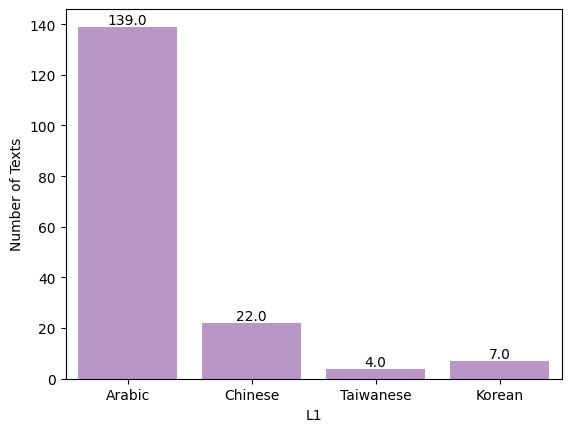

In [37]:
# visualizing L1s
L1 = sns.countplot(x='L1', data=Vercorpus,
                   color="#BB8FCE")
L1.set_ylabel('Number of Texts')
for p in L1.patches:
    height = p.get_height()
    L1.text(p.get_x()+p.get_width()/2., height +1, height, ha="center")
plt.savefig('../data_samples/visuals/lcorp_l1.png')
plt.show()

The documents are mostly produced by Arabic speakers, with a few documents from Chinese, Taiwanese, and Korean speakers. Not an ideal distribution, but it's what I have to work with. 

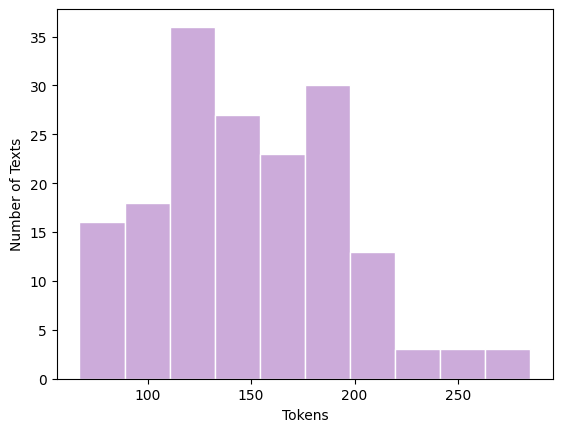

In [32]:
# lengths of texts
Tok_lens = Vercorpus['Tokens'].str.len()
Tokl = sns.histplot(Tok_lens, 
                    color='#BB8FCE',
                    edgecolor='white')
Tokl.set_ylabel('Number of Texts')
plt.savefig('../data_samples/visuals/lcorp_tok_len.png')
plt.show() 

In [33]:
print('Mean token length:', sum(Tok_lens)/len(Tok_lens))

Mean token length: 147.36046511627907


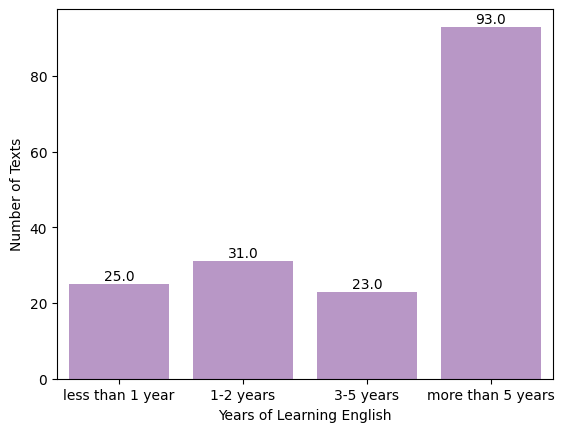

In [34]:
# years lerning english
y_order = ['less than 1 year', '1-2 years', '3-5 years', 'more than 5 years']
YL = sns.countplot(x='Years_Learn', data=Vercorpus,
                   color="#BB8FCE",
                   order= y_order)
YL.set_ylabel('Number of Texts')
YL.set_xlabel('Years of Learning English')
for p in YL.patches:
    height = p.get_height()
    YL.text(p.get_x()+p.get_width()/2., height +1, height, ha="center")
plt.savefig('../data_samples/visuals/lcorp_years_learn.png')
plt.show()

Most texts are produced by learners who have been learning English for more than 5 years, but there are also a decent number of texts produced by learners at earlier stages of acquisition, much more data than what was available in COREFL. Data is looking good. 

---

### Saving data

In [35]:
# pickling data
f = open('../data/Ncorpus_cont.pkl', 'wb')
pickle.dump(Ncorpus, f)
f.close()

f = open('../data/Lcorpus_cont.pkl', 'wb')
pickle.dump(Vercorpus, f)
f.close()

In [36]:
# storing data frames in public repo folder
Ncorpus.to_csv(r'../data_samples/Ncorpus_Prog2.csv', header=True)
Vercorpus.to_csv(r'../data_samples/Lcorpus_Prog2.csv', header=True)
id_map.to_csv(r'../data_samples/PELIC_Vercelloti_map.csv', header=True)